# Import Libraries

In [34]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import umap

from helper_codes.feat_importance import AutoFeatureImportance
from helper_codes.model_wrappers import LGBMWrapper
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

%matplotlib inline

# Read Data

In [3]:
train_data = pd.read_excel('./data/train_file.xlsx')

# Dataset Info

In [4]:
print('Training Data Shape:', train_data.shape)
train_data.head(5)

Training Data Shape: (32910, 15)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no


In [5]:
train_data.dtypes.value_counts()

object    11
int64      4
dtype: int64

In [6]:
train_data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,32910,32910,32910,32910,32910,32910,32910,32910,32910,32910,32910
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,8305,19929,9727,25975,17236,27099,20890,10993,6849,28380,29203


In [7]:
train_data.describe(include='int')

,age,duration,campaign,previous
count,32910.000000,32910.000000,32910.000000,32910.000000
mean,40.014099,258.164327,2.560620,0.174810
std,10.402948,259.070260,2.753336,0.499211
min,17.000000,0.000000,1.000000,0.000000
25%,32.000000,103.000000,1.000000,0.000000
50%,38.000000,180.000000,2.000000,0.000000
75%,47.000000,319.000000,3.000000,0.000000
max,98.000000,4918.000000,56.000000,7.000000


In [8]:
train_data.nunique().to_frame().T

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,75,12,4,8,3,3,3,2,10,5,1467,40,8,3,2


In [9]:
train_data.isna().sum().to_frame().T

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 
                'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num_features = ['age', 'duration', 'campaign', 'previous']

In [11]:
train_data['y_encoded'] = [1 if x == 'yes' else 0 for x in train_data.y]

# Response Distribution

In [12]:
train_data.y.value_counts(normalize=True)

no     0.887359
yes    0.112641
Name: y, dtype: float64

<AxesSubplot:xlabel='y', ylabel='count'>

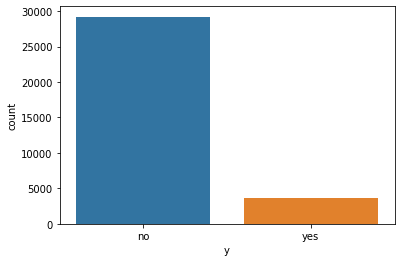

In [13]:
sns.countplot(x='y', data=train_data)

# Categorical Features

## Feature Distributions And Univariate Analysis

##################################################
job
##################################################



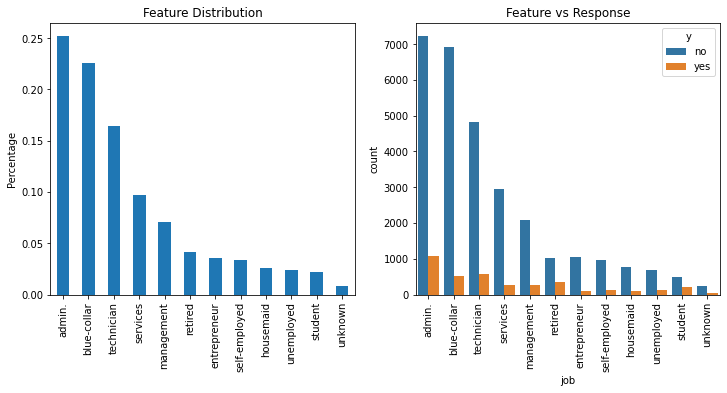

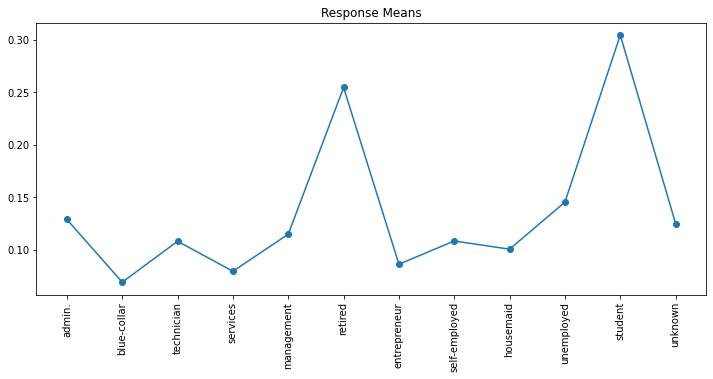


##################################################
marital
##################################################



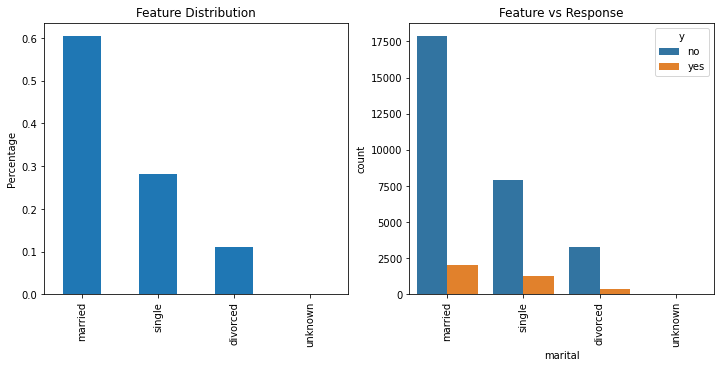

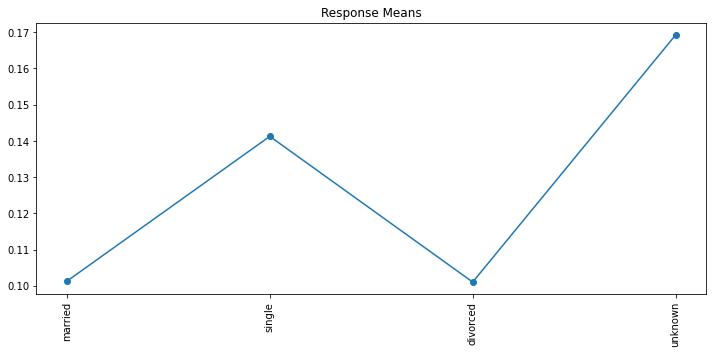


##################################################
education
##################################################



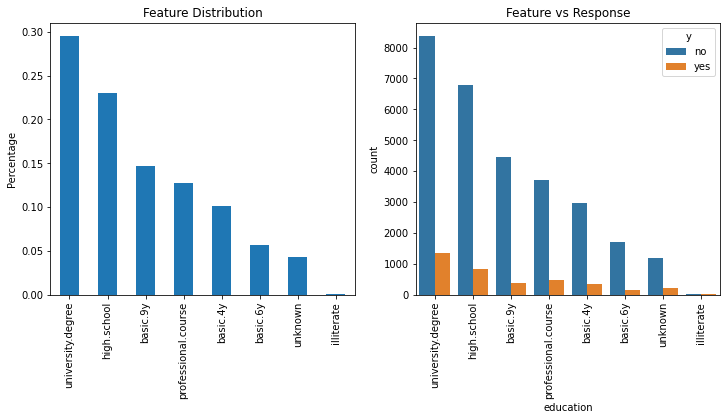

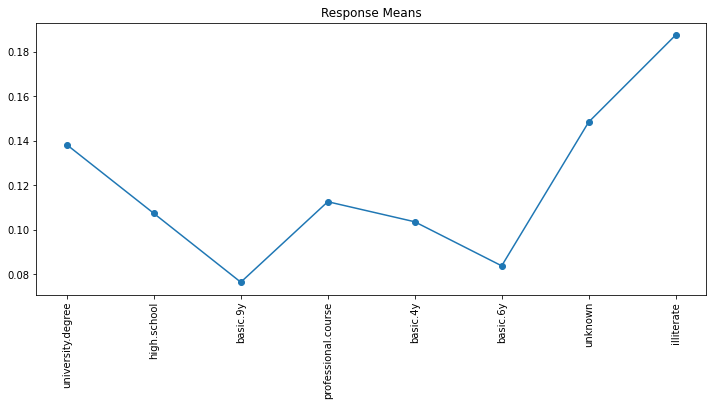


##################################################
default
##################################################



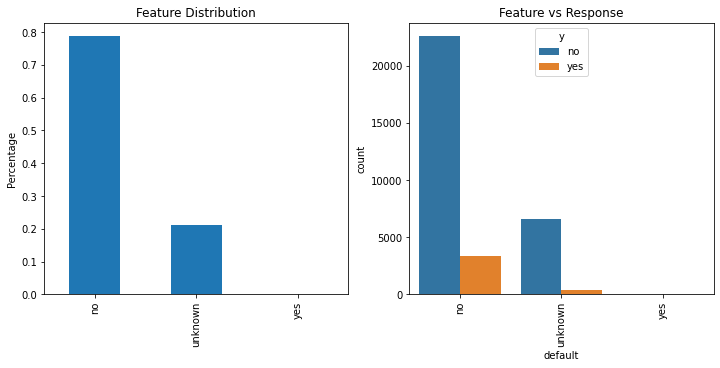

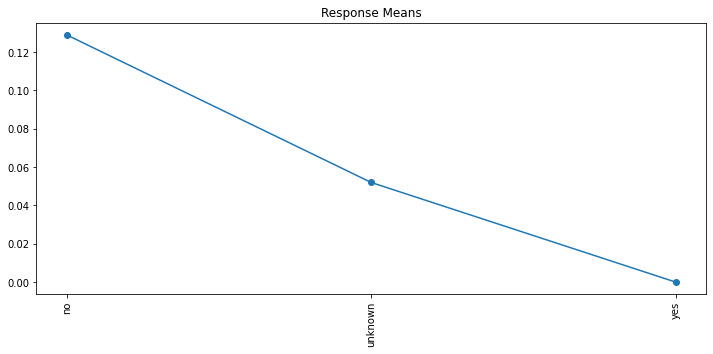


##################################################
housing
##################################################



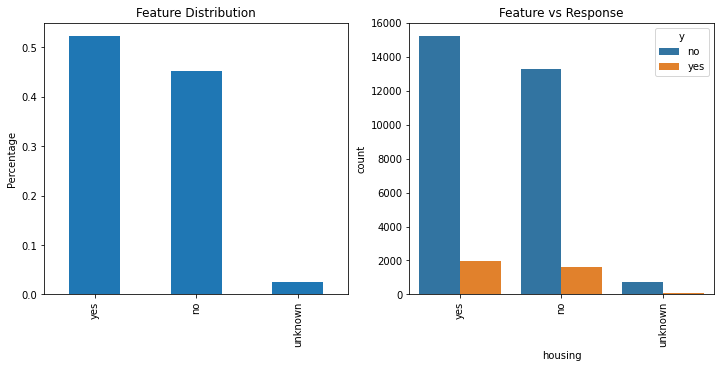

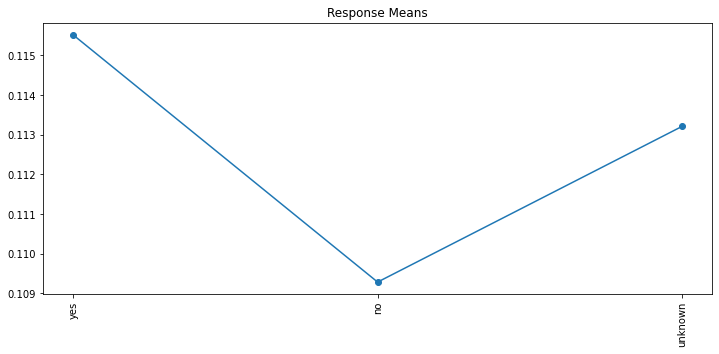


##################################################
loan
##################################################



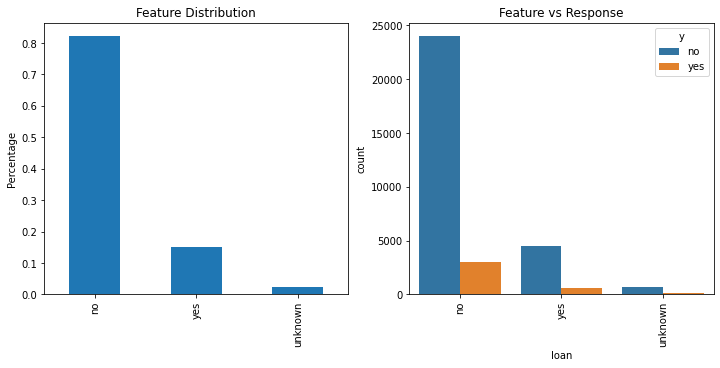

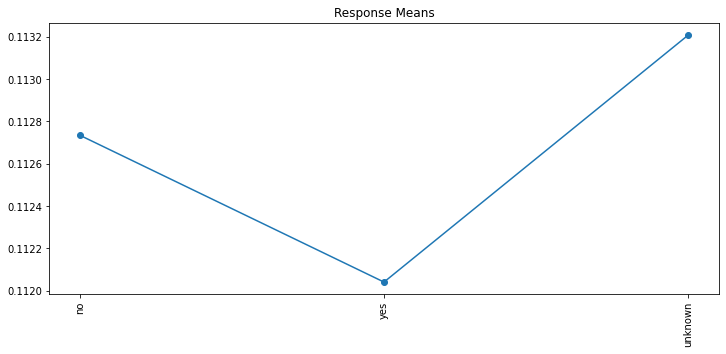


##################################################
contact
##################################################



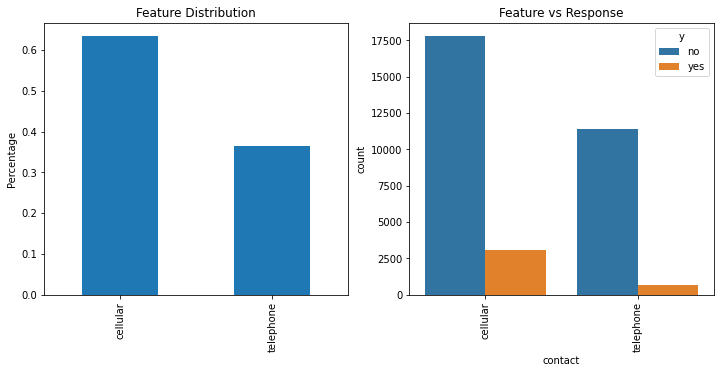

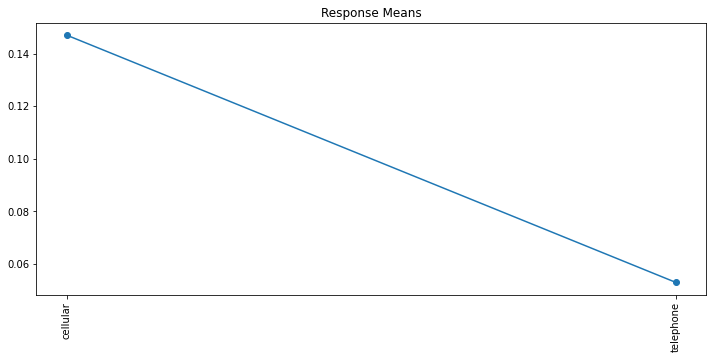


##################################################
month
##################################################



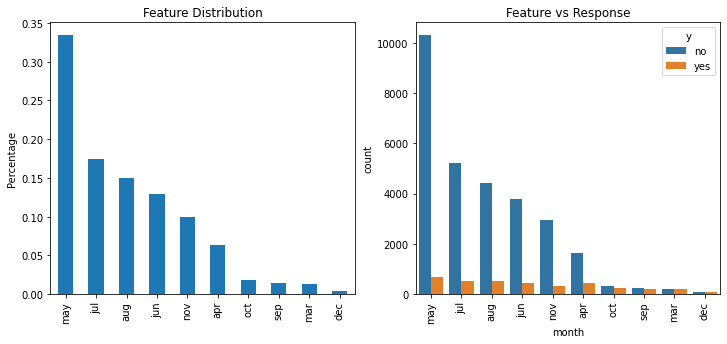

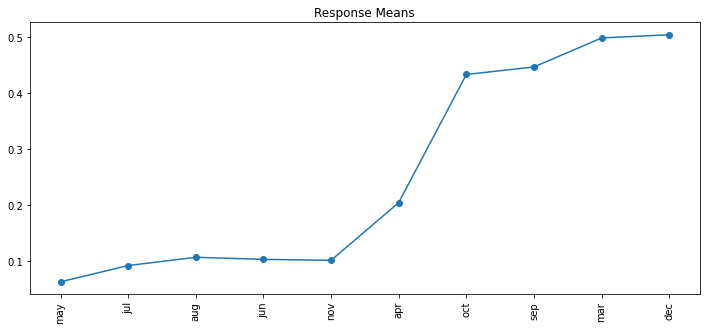


##################################################
day_of_week
##################################################



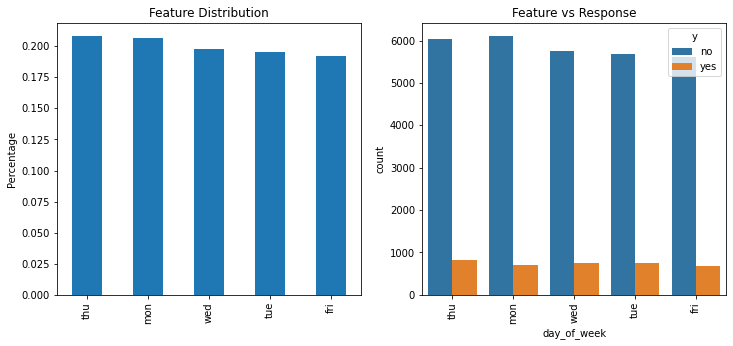

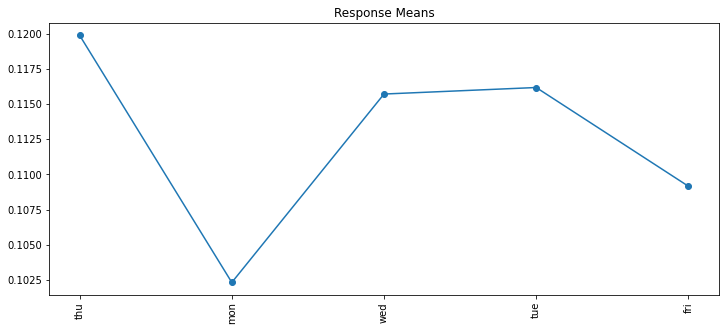


##################################################
poutcome
##################################################



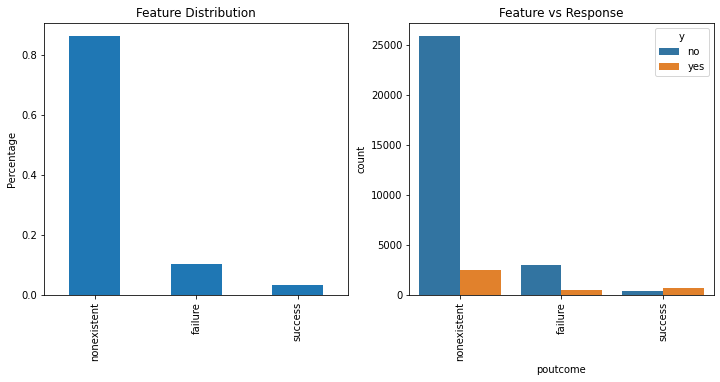

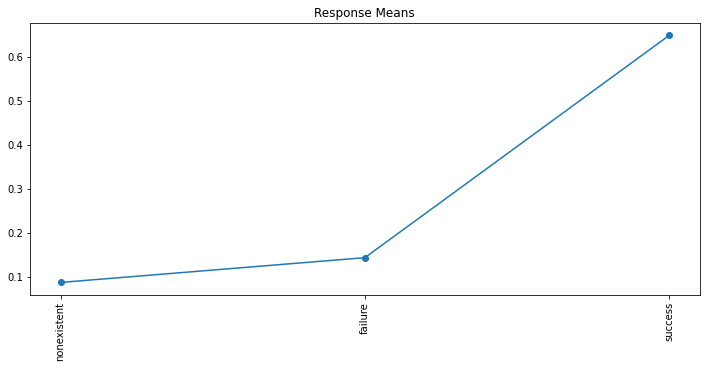

In [66]:
for col_name in cat_features:
    print("#" * 50)
    print(col_name)
    print("#" * 50)
    print()
    
    f, ax = plt.subplots(1,2,figsize=(12,5))
    train_data[col_name].value_counts(normalize=True).plot.bar(ax=ax[0])
    ax[0].set_title('Feature Distribution')
    ax[0].set_ylabel('Percentage')
    sns.countplot(col_name, hue='y', data=train_data, ax=ax[1], order=train_data[col_name].value_counts().index)
    ax[1].set_title('Feature vs Response')
    ax[1] = plt.xticks(rotation=90)
    plt.show()
    
    print()
    plt.figure(figsize=(12,5))
    grouped_df = train_data.groupby(col_name).agg({'y_encoded' : ['count', 'mean']}).reset_index()
    grouped_df.columns = grouped_df.columns.droplevel()
    grouped_df.columns = [col_name, 'count', 'y_encoded']
    grouped_df.sort_values('count', ascending=False, inplace=True)

    ax = plt.plot(col_name, 'y_encoded', data=grouped_df, linestyle='-', marker='o')
    ax = plt.xticks(rotation=90)
    ax = plt.title('Response Means')
    plt.show()
    print()
    #break

## Cramers_V Correlation Between Categorical Variables

In [14]:
auto_importance = AutoFeatureImportance(modelling_type='classification',
                                        data=train_data,
                                        response_column='y_encoded',
                                        categorical_columns=cat_features,
                                        numeric_columns=num_features,
                                        data_split=False,
                                        seed=24)

In [15]:
cramers_v_df = auto_importance.cramers_v_correlation()

In [16]:
cramers_v_df.sort_values('correlation_score', ascending=False).head()

,i,j,correlation_score
30,housing,loan,0.707876
39,contact,month,0.607693
1,job,education,0.359574
43,month,poutcome,0.246402
41,contact,poutcome,0.243075


# Numeric Features

## Histograms

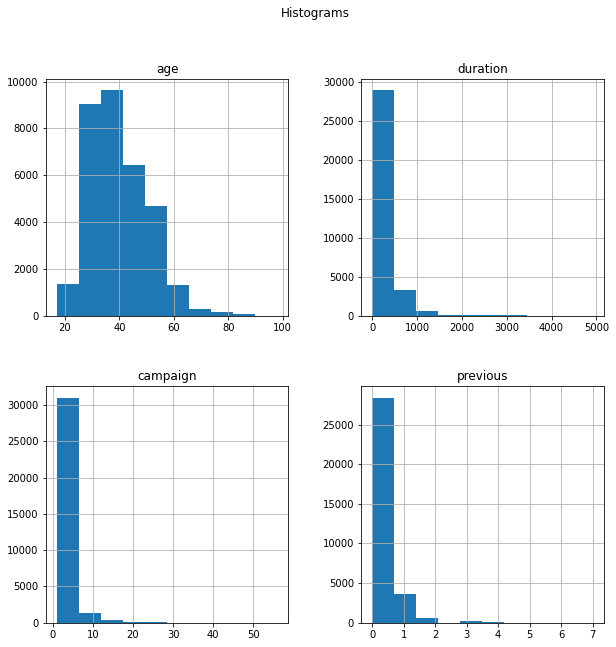

In [74]:
# Histograms
train_data[num_features].hist(figsize=(10,10))
plt.suptitle('Histograms')
plt.show()

In [80]:
for col_name in num_features:
    train_data[col_name+'_log'] = np.log(train_data[col_name] + 1)

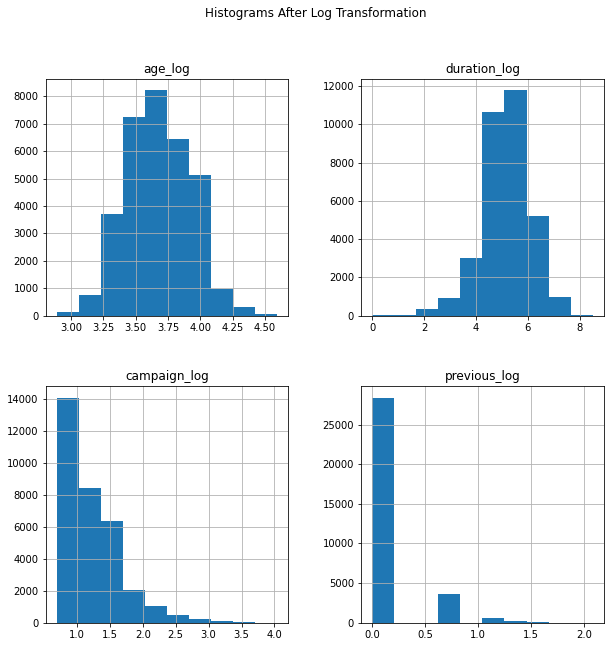

In [82]:
# Histograms of Features aftewr Log Transformations
train_data[[i+'_log' for i in num_features]].hist(figsize=(10,10))
plt.suptitle('Histograms After Log Transformation')
plt.show()

## Distributions Based On Response

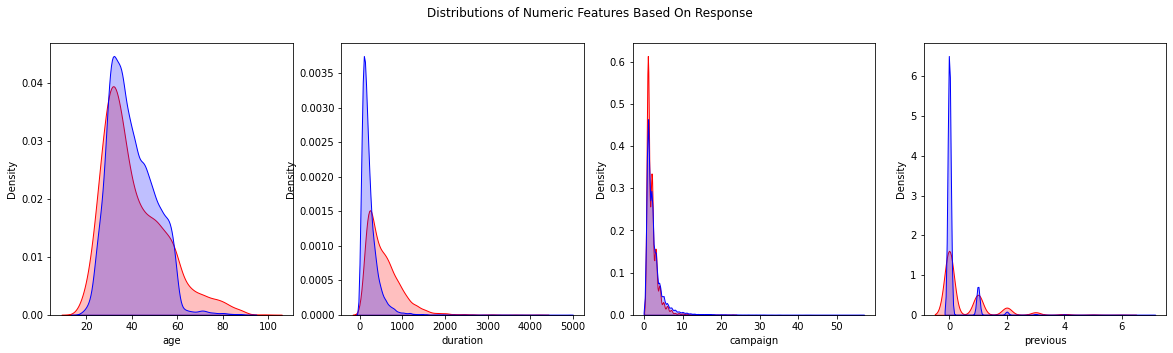

In [96]:
f, ax = plt.subplots(1,4,figsize=(20,5))
for idx, col_name in enumerate(num_features):
    sns.kdeplot(train_data[train_data.y == 'yes'][col_name], shade=True, color="r", ax=ax[idx])
    sns.kdeplot(train_data[train_data.y == 'no'][col_name], shade=True, color="b", ax=ax[idx])

    #sns.kdeplot(train_data[train_data.y == 'yes']['duration'], shade=True, color="r", ax=ax[1])
    #sns.kdeplot(train_data[train_data.y == 'no']['duration'], shade=True, color="b", ax=ax[1])
plt.suptitle('Distributions of Numeric Features Based On Response')
plt.show()

## Boxplots Based on Response

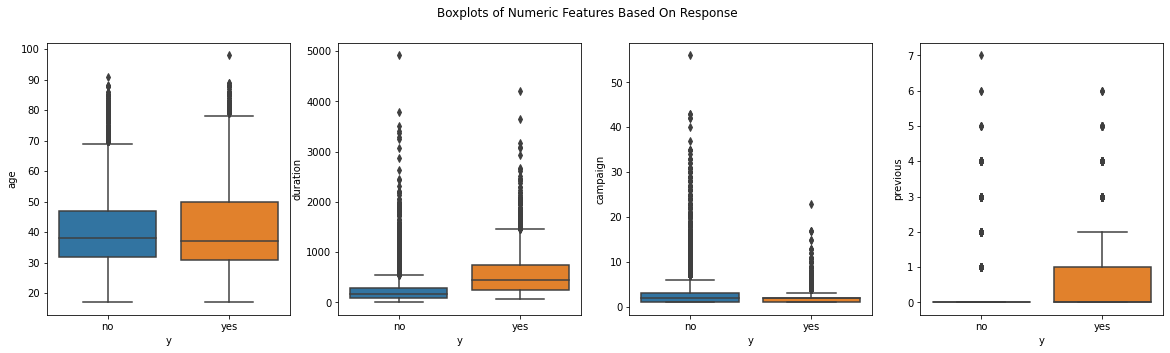

In [100]:
f, ax = plt.subplots(1,4,figsize=(20,5))
for idx, col_name in enumerate(num_features):
    sns.boxplot( x=train_data["y"], y=train_data[col_name], ax=ax[idx])

plt.suptitle('Boxplots of Numeric Features Based On Response')
plt.show()

## Correlations

<AxesSubplot:>

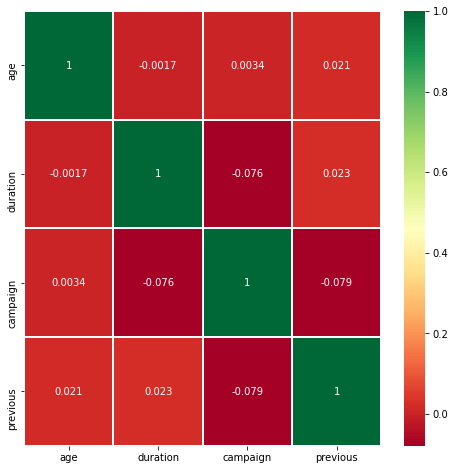

In [109]:
plt.figure(figsize=(8,8))
sns.heatmap(train_data[num_features].corr(), annot=True, cmap='RdYlGn', linewidths=0.1)


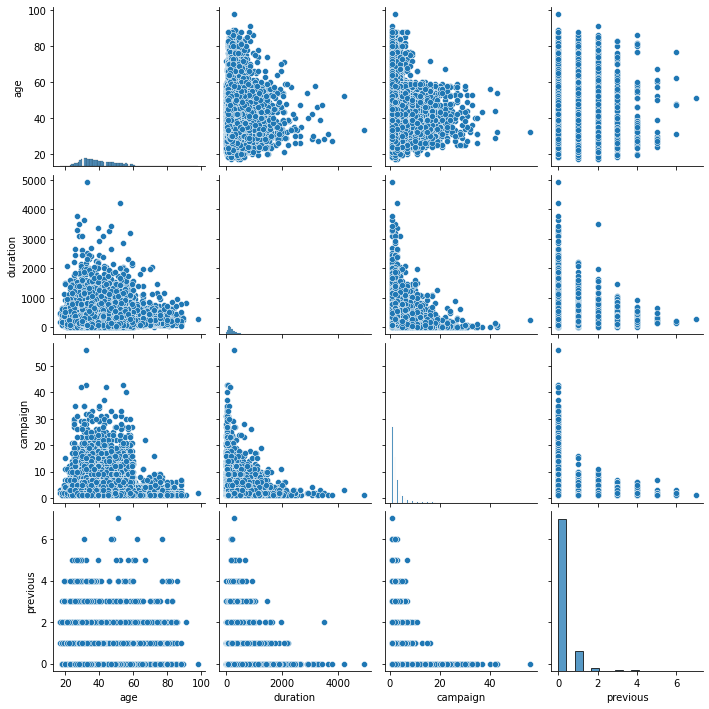

In [124]:
sns.pairplot(train_data[num_features], palette="coolwarm")

## Numeric Features vs Response

In [152]:
for col_name in num_features:
    train_data[col_name+'_bin'] = (pd.cut(train_data[col_name], bins=10)).astype('string')

In [153]:
col_name = "previous_bin"

In [154]:
train_data[col_name]

0        (-0.007, 0.7]
1           (0.7, 1.4]
2        (-0.007, 0.7]
3        (-0.007, 0.7]
4        (-0.007, 0.7]
             ...      
32905       (0.7, 1.4]
32906    (-0.007, 0.7]
32907    (-0.007, 0.7]
32908    (-0.007, 0.7]
32909    (-0.007, 0.7]
Name: previous_bin, Length: 32910, dtype: string

##################################################
age_bin
##################################################



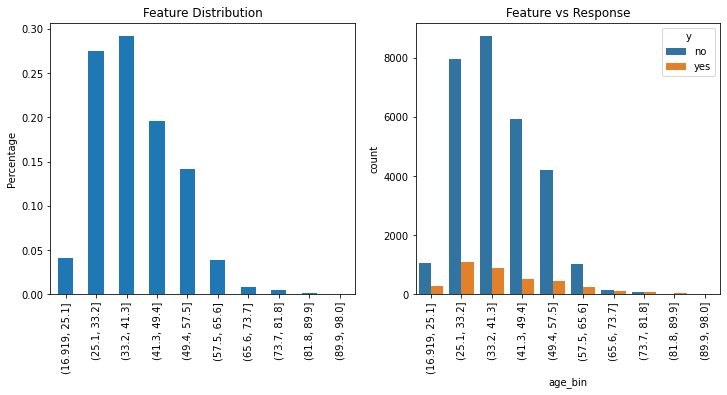

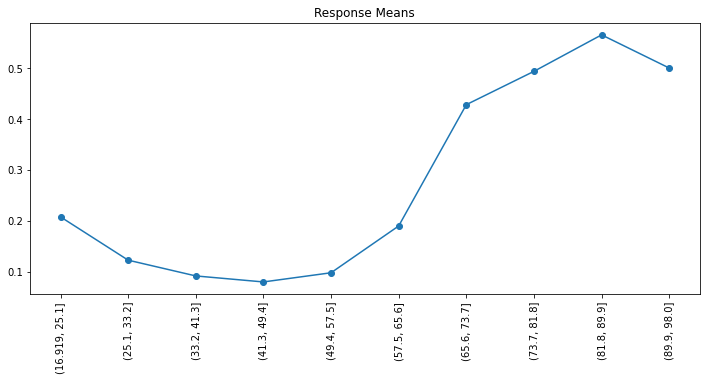


##################################################
duration_bin
##################################################



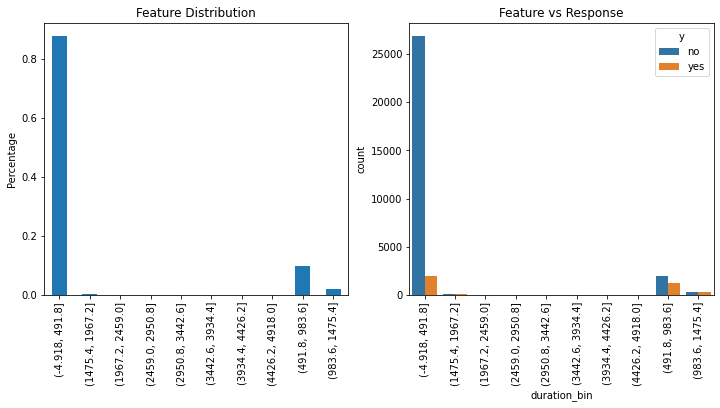

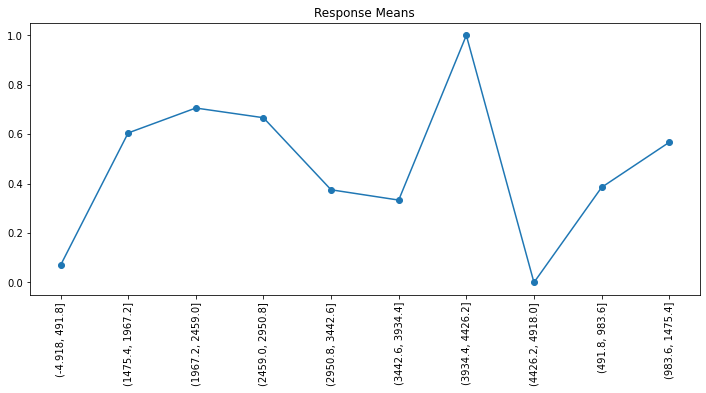


##################################################
campaign_bin
##################################################



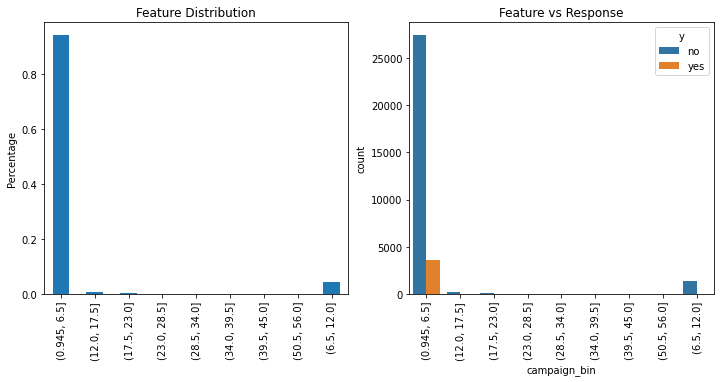

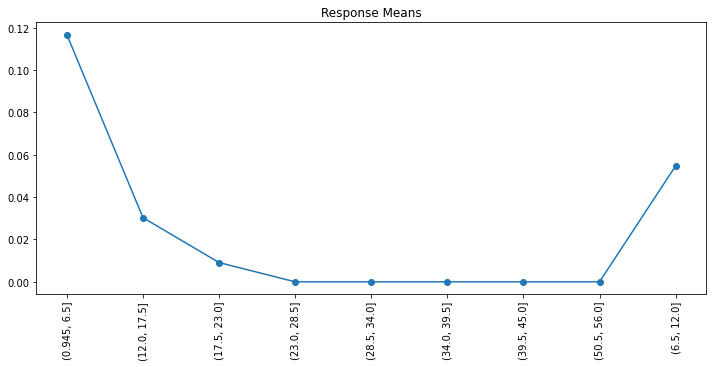


##################################################
previous_bin
##################################################



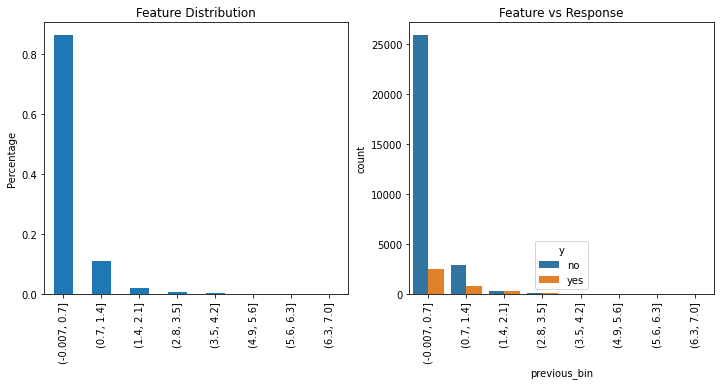

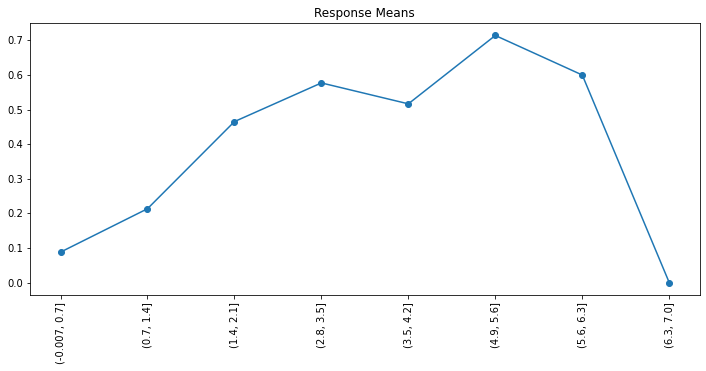

In [157]:
for col_name in [x for x in train_data if '_bin' in x]:
    print("#" * 50)
    print(col_name)
    print("#" * 50)
    print()
    
    f, ax = plt.subplots(1,2,figsize=(12,5))
    train_data[col_name].value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
    ax[0].set_title('Feature Distribution')
    ax[0].set_ylabel('Percentage')
    sns.countplot(col_name, hue='y', data=train_data, ax=ax[1], order=train_data[col_name].value_counts().sort_index().index)
    ax[1].set_title('Feature vs Response')
    ax[1] = plt.xticks(rotation=90)
    plt.show()
    
    print()
    plt.figure(figsize=(12,5))
    grouped_df = train_data.groupby(col_name).agg({'y_encoded' : ['count', 'mean']}).reset_index()
    grouped_df.columns = grouped_df.columns.droplevel()
    grouped_df.columns = [col_name, 'count', 'y_encoded']
    grouped_df.sort_values(col_name, ascending=True, inplace=True)

    ax = plt.plot(col_name, 'y_encoded', data=grouped_df, linestyle='-', marker='o')
    ax = plt.xticks(rotation=90)
    ax = plt.title('Response Means')
    plt.show()
    print()
    #break

# Visualization with TSNE

In [87]:
cat_transformer = Pipeline(steps=[
                                    ('encoder', TargetEncoder()),
                                    ('scaler', StandardScaler())
                                ])

num_transformer = Pipeline(steps=[
                                    ('scaler', StandardScaler())
                                ])

preprocessor = ColumnTransformer(transformers=[
                                                ('num_trans', num_transformer, num_features),
                                                ('cat_trans', cat_transformer, cat_features)
                                            ],
                                remainder='drop')

X_train = preprocessor.fit_transform(train_data[cat_features+num_features], train_data.y_encoded)

In [71]:
tsne = TSNE()
train_tsne = tsne.fit_transform(X_train)

In [75]:
tsne_df = pd.DataFrame(train_tsne)
tsne_df['y'] = train_data.y_encoded.values

<AxesSubplot:xlabel='0', ylabel='1'>

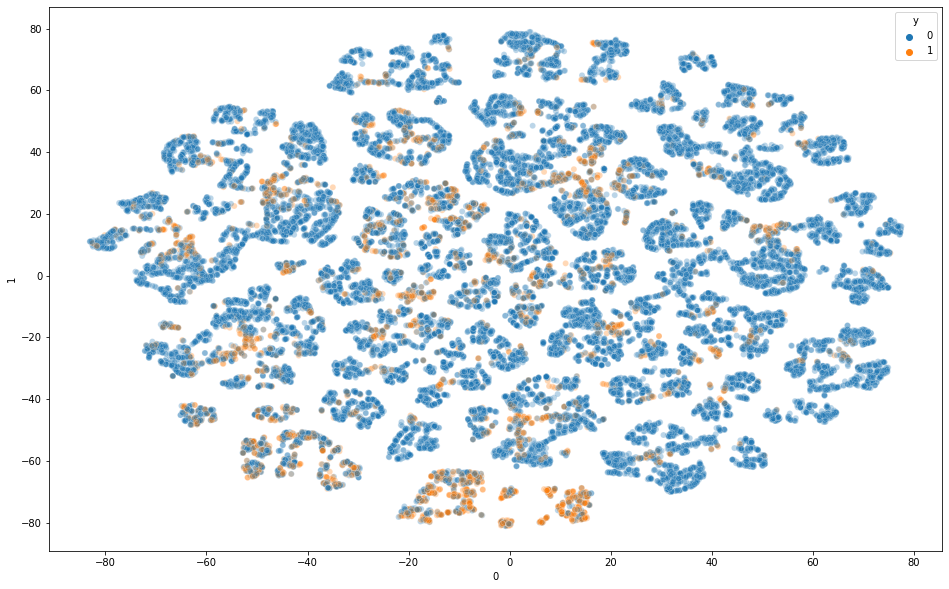

In [80]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=1,
    hue="y",
    data=tsne_df,
    legend="full",
    alpha=0.3
)

# Visualization with UMAP

In [88]:
manifold = umap.UMAP()
train_umap = manifold.fit_transform(X_train)

In [89]:
umap_df = pd.DataFrame(train_umap)
umap_df['y'] = train_data.y.values

<AxesSubplot:xlabel='0', ylabel='1'>

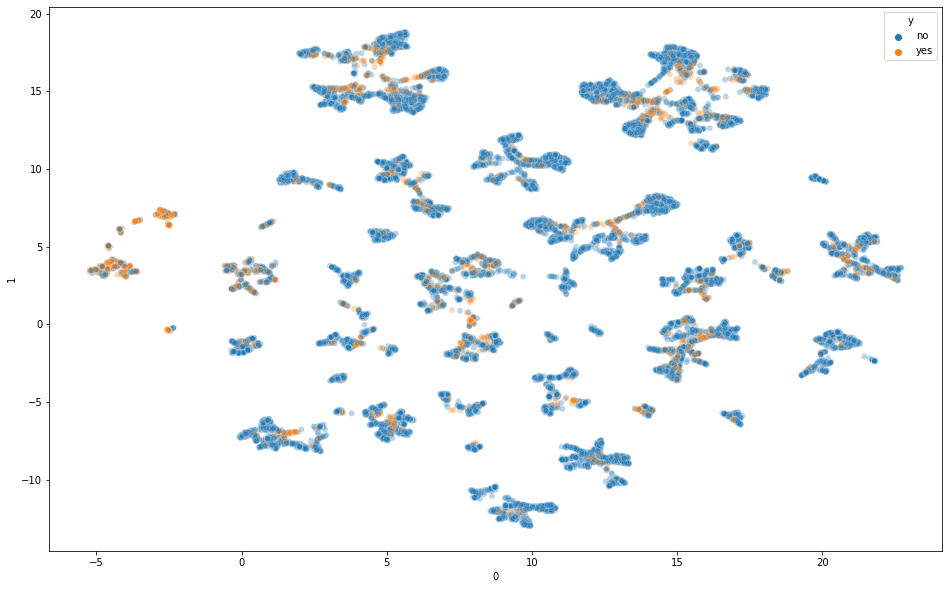

In [90]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=1,
    hue="y",
    data=umap_df,
    legend="full",
    alpha=0.3
)

# Feature Importance

In [21]:
for col_name in cat_features:
    train_data[col_name] = train_data[col_name].astype('category')

In [25]:
auto_importance = AutoFeatureImportance(modelling_type='classification',
                                        data=train_data,
                                        response_column='y_encoded',
                                        categorical_columns=cat_features,
                                        numeric_columns=num_features,
                                        data_split=False,
                                        seed=24)

In [26]:
lgbm_hyperparam_dict = {
    'learning_rate' : 0.1, 'max_depth' : 5, 'n_estimators' : 200, 'num_leaves' : 20,
    'random_state' : 24, 'n_jobs' : -1, 'importance_type' : 'gain', 'objective' : 'binary'
}

xgb_hyperparam_dict = {
    'learning_rate' : 0.1, 'max_depth' : 5, 'n_estimators' : 200,
    'random_state' : 24, 'n_jobs' : -1, 'importance_type' : 'gain', 'objective' : 'binary:logistic'
}

rf_hyperparam_dict = {
    'max_depth' : 5, 'n_estimators' : 200, 'random_state' : 24, 'n_jobs' : -1
}

In [27]:
final_importance_df = auto_importance.auto_select(importance_types=['lgbm', 'xgb', 'rf', 'lassocv',
                                                                    'perimp', 'rfecv', 'boruta'],
                                          lgbm_hyperparams=lgbm_hyperparam_dict,
                                          xgb_hyperparams=xgb_hyperparam_dict,
                                          rf_hyperparams=rf_hyperparam_dict)

LightGBM Feature Importance is finished
[18:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Feature Importance is finished
Random Forest Feature Importance is finished
LassoCV Feature Importance is finished
Error in ELI5 Permutation Importance Feature Importance
RFECV Feature Importance is finished
Boruta Feature Importance is finished


### Adding Permutation Importance

Due to compatibility issues of Latest Eli5 package, Permution Importance is externally calculated with Sklearn and added to the final feature importance dataframe

In [35]:
#LightGBM Model for Permutation Importance
model = LGBMWrapper(modelling_type='classification', hyperparams=lgbm_hyperparam_dict, return_probability=True)
model.fit(X_train=auto_importance.X_train, y_train=auto_importance.y_train)

In [36]:
#Permutation Importance
permimp_results = permutation_importance(model.model, auto_importance.X_train, auto_importance.y_train,
                                         scoring='roc_auc', n_repeats=5, n_jobs=4, random_state=24)

In [37]:
permimp_results = pd.DataFrame({'feature':auto_importance.X_train.columns, 'permimp_importance':permimp_results['importances_mean']})

In [38]:
#Adding Permutation Importance Results to Final Importance DataFrame
final_importance_df = final_importance_df.merge(permimp_results, on='feature', how='left')

## Final Feature Importance Results

In [40]:
#final_importance_df.to_excel('feature_importance_scores.xlsx', index=False)

In [116]:
final_importance_df

,feature,lgbm_importance,xgb_importance,rf_importance,lassocv_coefs,rfecv_rankings,boruta_ranking,boruta_support,boruta_weak_support,permimp_importance
0,duration,30337.768293,0.118477,0.453911,0.000488,1,1,True,False,0.273835
1,month,10680.816710,0.086254,0.149367,0.000000,1,1,True,False,0.061139
2,poutcome,9937.925178,0.390661,0.218841,0.000000,1,1,True,False,0.012666
3,age,4034.499533,0.026518,0.047742,0.000587,1,1,True,False,0.015374
4,contact,2069.322685,0.119887,0.026387,0.000000,1,1,True,False,0.023410
5,previous,1655.728367,0.044325,0.053751,0.007847,1,1,True,False,0.003865
6,job,1418.755414,0.030774,0.023120,0.000000,1,1,True,False,0.005766
7,campaign,1161.589572,0.017009,0.004968,0.000000,1,2,False,False,0.008448
8,default,890.212110,0.085214,0.007975,0.000000,1,1,True,False,0.006008
9,day_of_week,514.594109,0.020489,0.004196,0.000000,1,2,False,False,0.003885


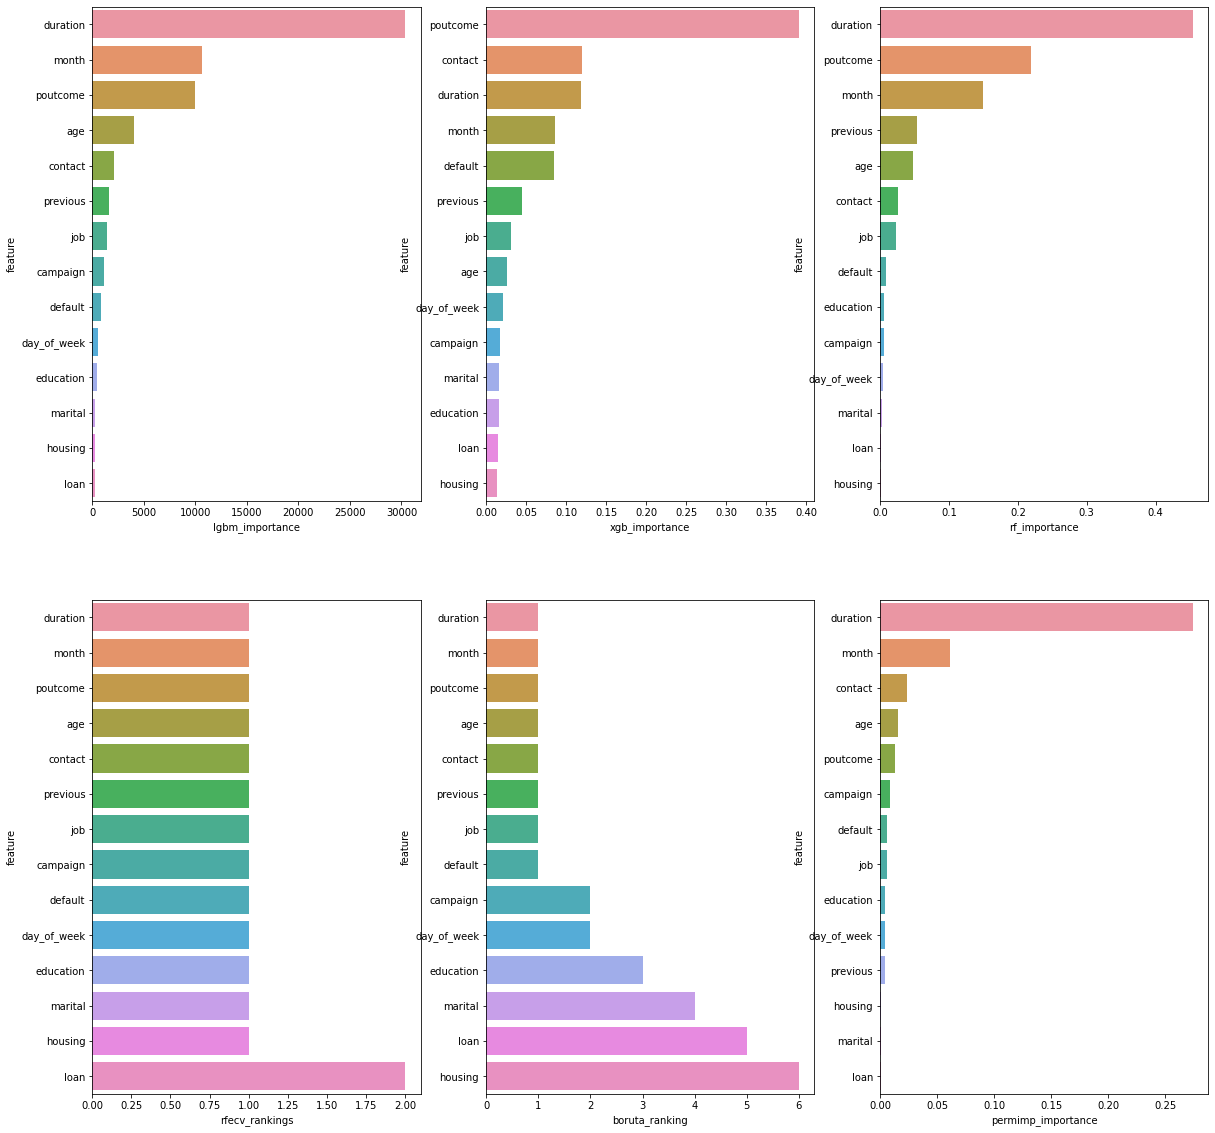

In [127]:
f, ax = plt.subplots(2,3,figsize=(20,20))

sns.barplot(x='lgbm_importance', y='feature', data=final_importance_df.sort_values('lgbm_importance', ascending=False), ax=ax[0,0])
sns.barplot(x='xgb_importance', y='feature', data=final_importance_df.sort_values('xgb_importance', ascending=False), ax=ax[0,1])
sns.barplot(x='rf_importance', y='feature', data=final_importance_df.sort_values('rf_importance', ascending=False), ax=ax[0,2])
sns.barplot(x='rfecv_rankings', y='feature', data=final_importance_df.sort_values('rfecv_rankings', ascending=True), ax=ax[1,0])
sns.barplot(x='boruta_ranking', y='feature', data=final_importance_df.sort_values('boruta_ranking', ascending=True), ax=ax[1,1])
sns.barplot(x='permimp_importance', y='feature', data=final_importance_df.sort_values('permimp_importance', ascending=False), ax=ax[1,2])
plt.show()

# Feature Engineering

## Rare Classes

In [95]:
for col_name in cat_features:
    print(col_name)
    print(train_data[col_name].value_counts(normalize=True)[train_data[col_name].value_counts(normalize=True) < 0.01])
    print()

job
unknown    0.008022
Name: job, dtype: float64

marital
unknown    0.001975
Name: marital, dtype: float64

education
illiterate    0.000486
Name: education, dtype: float64

default
yes    0.000091
Name: default, dtype: float64

housing
Series([], Name: housing, dtype: float64)

loan
Series([], Name: loan, dtype: float64)

contact
Series([], Name: contact, dtype: float64)

month
dec    0.004345
Name: month, dtype: float64

day_of_week
Series([], Name: day_of_week, dtype: float64)

poutcome
Series([], Name: poutcome, dtype: float64)



In [96]:
for col_name in cat_features:
    train_data[col_name] = train_data[col_name].astype('object')

In [104]:
train_data.job.replace('unknown', 'admin.', inplace=True)
train_data.marital.replace('unknown', 'married', inplace=True)
train_data.education.replace('illiterate', 'unknown', inplace=True)
train_data.default.replace('yes', 'unknown', inplace=True)

In [107]:
train_data.month.unique()

array(['nov', 'jul', 'may', 'jun', 'aug', 'mar', 'oct', 'apr', 'sep',
       'dec'], dtype=object)

In [108]:
train_data['quarter'] = ['q1' if x in ['jan', 'feb', 'mar'] else
                         'q2' if x in ['apr', 'may', 'jun'] else
                         'q3' if x in ['jul', 'aug', 'sep'] else
                         'q4' for x in train_data.month]

In [115]:
train_data.to_pickle('./data/train_file_eng.pkl')